In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
import matplotlib as mpl
from matplotlib.colors import rgb2hex


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_cal = pd.read_csv('calendar.csv')
df_list = pd.read_csv('listings.csv')

# Exploratory data analysis

In [3]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [4]:
df_cal.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

Note that in the price column there are 459028 out of 1393570 (32.94%) missing values. Seems like when a property is not available the price is NaN.

In [5]:
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
# Change date to datetime
df_cal['date'] = pd.to_datetime(df_cal['date'])

In [7]:
df_cal['listing_id'].nunique()
df_cal['date'].nunique()

3818

365

In [8]:
df_cal['date'].min()
df_cal['date'].max()

Timestamp('2016-01-04 00:00:00')

Timestamp('2017-01-02 00:00:00')

The dataframe df_cal has 1393570 rows which contain information for 3818 properties for 365 days (from Jan 4, 2016 to Jan 2, 2017). 
The 'price' column is of type object and has a dollar sign and ',' as separator. We will remove them and convert the column to numeric.

In [9]:
# Clean 'price'
df_cal['price'] = df_cal['price'].str.replace('$','').str.replace(',','').astype(float)

How many of the houses were rented at least once during our observarion period?

In [10]:
# Convert 'available' to boolean
df_cal.loc[df_cal['available']=='t', 'available'] = True
df_cal.loc[df_cal['available']=='f', 'available'] = False
df_cal['available'] = df_cal['available'].astype(bool)

In [11]:
#create aggregate table
df_cal_agg = pd.DataFrame({
    'booked_days': 365 - df_cal.groupby('listing_id')['available'].sum(),
    'min_price': df_cal.groupby('listing_id')['price'].min(),
    'max_price': df_cal.groupby('listing_id')['price'].max(),
#    'min_max_price_diff': df_cal.groupby('listing_id')['price'].apply(lambda x: max(x) - min(x)) # FIXME: why doesn't this work?!?!
}).reset_index()

In [12]:
df_cal_agg.head()

,listing_id,booked_days,min_price,max_price
0,3335,56.0,120.0,120.0
1,4291,0.0,82.0,82.0
2,5682,56.0,42.0,60.0
3,6606,0.0,90.0,100.0
4,7369,312.0,85.0,85.0


In [13]:
print('There were {} properties that were never booked and {} that were booked all of the time!' \
      .format(df_cal_agg[df_cal_agg['booked_days'] == 0]['listing_id'].nunique(), df_cal_agg[df_cal_agg['booked_days'] == 365]['listing_id'].nunique()))

There were 678 properties that were never booked and 95 that were booked all of the time!


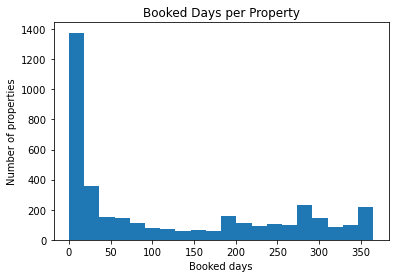

In [14]:
plt.hist(df_cal_agg['booked_days'], bins=20)
plt.title('Booked Days per Property')
plt.xlabel('Booked days')
plt.ylabel('Number of properties')

plt.savefig('Booked Days per Property');

In [15]:
print('Percentage of never booked properties:', df_cal_agg[df_cal_agg['booked_days'] == 0].shape[0]/df_cal_agg.shape[0]*100)
print('Percentage of properties booked less than 10% of the time:', df_cal_agg[(df_cal_agg['booked_days'] > 0) & (df_cal_agg['booked_days'] < 0.1*365)].shape[0]/df_cal_agg.shape[0]*100)
print('Percentage of properties booked more than 75% of the time:', df_cal_agg[df_cal_agg['booked_days'] > 0.75*365].shape[0]/df_cal_agg.shape[0]*100)

Percentage of never booked properties: 17.7579884756417
Percentage of properties booked less than 10% of the time: 27.658459926663177
Percentage of properties booked more than 75% of the time: 20.27239392352017


Surprisingly, most of the properties were either never booked or booked less than 10% of the time. 

Now let's look at the dataset containing more information about the properties.

In [16]:
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [17]:
number_prop = df_cal['listing_id'].nunique()
print("The table df_list contains information about {} listings (same as df_cal?).".format(number_prop))

The table df_list contains information about 3818 listings (same as df_cal?).


Most of the columns have pretty good coverage. Only 'license' and 'square_feet' have 0 and 97 non-null elements resp.
Again, the columns containing price need to be cleaned.

In [18]:
# Clean the price fields
for pr in ['price', 'weekly_price', 'monthly_price']:
    df_list[pr] = df_list[pr].str.replace('$','').str.replace(',','').astype(float)

In [19]:
# Get unique values per column
for col in ['state', 'city', 'zipcode', 'cancellation_policy', 'property_type', 'room_type']:
    print(df_list[col].unique())

['WA' 'wa']
['Seattle' 'Ballard, Seattle' 'West Seattle' 'Seattle ' '西雅图'
 'Phinney Ridge Seattle' 'seattle']
['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98101'
 '98122' '98112' '98144' '99\n98122' '98121' '98102' '98199' '98104'
 '98134' '98136' '98126' '98146' '98116' '98177' '98118' '98108' '98133'
 '98106' '98178' '98125']
['moderate' 'strict' 'flexible']
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Bed & Breakfast' 'Other' 'Dorm' 'Treehouse'
 'Yurt' 'Chalet' 'Tent' nan]
['Entire home/apt' 'Private room' 'Shared room']


# Merge the two dataset

In [20]:
# Right merge df_list and df_cal_agg
df = df_list[['id', 'price', 'zipcode', 'bedrooms', 'accommodates', 'number_of_reviews', 'cancellation_policy', 'property_type', 'room_type']] \
        .merge(df_cal_agg, how='right', left_on='id', right_on='listing_id')

In [21]:
df.shape
df.info()

(3818, 13)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3818 non-null   int64  
 1   price                3818 non-null   float64
 2   zipcode              3811 non-null   object 
 3   bedrooms             3812 non-null   float64
 4   accommodates         3818 non-null   int64  
 5   number_of_reviews    3818 non-null   int64  
 6   cancellation_policy  3818 non-null   object 
 7   property_type        3817 non-null   object 
 8   room_type            3818 non-null   object 
 9   listing_id           3818 non-null   int64  
 10  booked_days          3818 non-null   float64
 11  min_price            3723 non-null   float64
 12  max_price            3723 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 417.6+ KB


In [22]:
df.head(10)

,id,price,zipcode,bedrooms,accommodates,number_of_reviews,cancellation_policy,property_type,room_type,listing_id,booked_days,min_price,max_price
0,241032,85.0,98119,1.0,4,207,moderate,Apartment,Entire home/apt,241032,19.0,85.0,85.0
1,953595,150.0,98119,1.0,4,43,strict,Apartment,Entire home/apt,953595,74.0,125.0,439.0
2,3308979,975.0,98119,5.0,11,20,strict,House,Entire home/apt,3308979,145.0,500.0,1650.0
3,7421966,100.0,98119,0.0,3,0,flexible,Apartment,Entire home/apt,7421966,222.0,100.0,100.0
4,278830,450.0,98119,3.0,6,38,strict,House,Entire home/apt,278830,0.0,450.0,600.0
5,5956968,120.0,98119,1.0,2,17,strict,House,Private room,5956968,63.0,120.0,140.0
6,1909058,80.0,98119,1.0,2,58,moderate,House,Private room,1909058,19.0,80.0,80.0
7,856550,60.0,98119,1.0,2,173,strict,Cabin,Private room,856550,265.0,42.0,62.0
8,4948745,90.0,98109,1.0,2,8,strict,Apartment,Private room,4948745,24.0,90.0,90.0
9,2493658,150.0,98119,1.0,4,32,strict,Apartment,Entire home/apt,2493658,41.0,125.0,439.0


## What's the most popular property size?

Since the column 'square_feet' contains only 97 non-null elements, we're going to use the number of bedrooms as proxy for the size.
The most popular size for house is with 1 bedroom, followed by 2 and 0 bedrooms. There are less than 100 properties with more than 3 bedrooms. 

In [23]:
print('Since there are only {}% rows with missing values we are going to drop them.'.format(round(df['bedrooms'].isnull().mean()*100, 2)))

Since there are only 0.16% rows with missing values we are going to drop them.


In [24]:
df = df[~df['bedrooms'].isnull()]

In [25]:
df['bedrooms'].value_counts()

1.0    2417
2.0     640
0.0     372
3.0     283
4.0      69
5.0      24
6.0       6
7.0       1
Name: bedrooms, dtype: int64

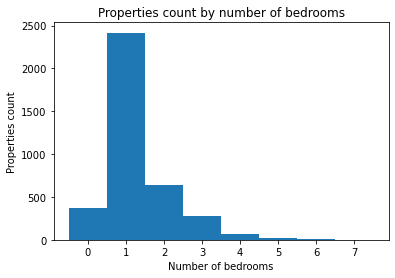

In [26]:
#center the bins at the integers and plt a histogram
bins = np.arange(df['bedrooms'].min(), df['bedrooms'].max() + 1.5) - 0.5
plt.hist(df['bedrooms'], bins=bins)
plt.title('Properties count by number of bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Properties count')
plt.savefig('Properties count by number of bedrooms');

We see that the most of the listed properties are with 1 bedroom, followed by the ones with 2 bedrooms, and studios. But let's check how many of these properties (as %) got booked. To do this we first sum all days on which such properties were booked and normalize by dividing by the total number of days the properties were available (365).

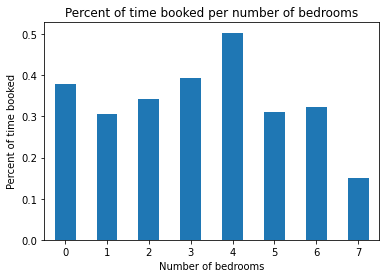

In [27]:
grouped_bedrooms= df.groupby('bedrooms')['booked_days'].apply(lambda x: x.sum()/(x.count()*365))
# grouped_bedrooms['bedrooms'] = grouped_bedrooms['bedrooms'].astype(int)
grouped_bedrooms.plot(kind='bar')
plt.xticks([0, 1, 2,3, 4, 5, 6, 7], [0, 1, 2,3, 4, 5, 6, 7], rotation=0)
plt.xlabel('Number of bedrooms')
plt.ylabel('Percent of time booked')
plt.title('Percent of time booked per number of bedrooms')
plt.savefig('Percent of time booked per number of bedrooms');

In [28]:
df[df['bedrooms'] == 4].describe()

,id,price,bedrooms,accommodates,number_of_reviews,listing_id,booked_days,min_price,max_price
count,6.900000e+01,69.000000,69.0,69.000000,69.000000,6.900000e+01,69.000000,61.000000,61.000000
mean,5.872371e+06,313.695652,4.0,8.275362,8.246377,5.872371e+06,183.753623,288.196721,357.639344
std,2.919063e+06,122.384676,0.0,2.042807,12.121209,2.919063e+06,138.895793,129.163181,141.768595
min,1.070460e+05,150.000000,4.0,4.000000,0.000000,1.070460e+05,0.000000,10.000000,150.000000
25%,3.561237e+06,244.000000,4.0,8.000000,1.000000,3.561237e+06,32.000000,199.000000,250.000000
50%,6.386210e+06,295.000000,4.0,8.000000,3.000000,6.386210e+06,193.000000,250.000000,349.000000
75%,8.225635e+06,350.000000,4.0,8.000000,12.000000,8.225635e+06,320.000000,350.000000,450.000000
max,1.025211e+07,775.000000,4.0,16.000000,59.000000,1.025211e+07,365.000000,775.000000,775.000000


### By property type

In [29]:
print('Since there are only {}% rows with missing values we are going to drop them.'.format(round(df['property_type'].isnull().mean()*100, 2)))

Since there are only 0.03% rows with missing values we are going to drop them.


In [30]:
df = df[~df['property_type'].isnull()]
df.isnull().sum()

id                      0
price                   0
zipcode                 7
bedrooms                0
accommodates            0
number_of_reviews       0
cancellation_policy     0
property_type           0
room_type               0
listing_id              0
booked_days             0
min_price              95
max_price              95
dtype: int64

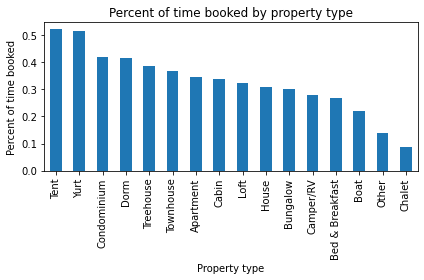

In [31]:
grouped_prop_type = df.groupby('property_type')['booked_days'].apply(lambda x: x.sum()/(x.count()*365)).sort_values(ascending=False)
grouped_prop_type.plot(kind='bar')
plt.xlabel('Property type')
plt.ylabel('Percent of time booked')
plt.title('Percent of time booked by property type')
plt.tight_layout()
plt.savefig('Percent of time booked by property type');

## What is the most popular location?

In [32]:
print('There are only {}% missing values in this column so we will drop these rows.'.format(round(df['zipcode'].isnull().mean()*100, 2)))

There are only 0.18% missing values in this column so we will drop these rows.


In [33]:
df = df[~df['zipcode'].isnull()]
df['zipcode'].value_counts()

98122        420
98103        394
98102        338
98105        225
98109        202
98144        200
98101        199
98121        195
98107        180
98115        178
98112        166
98117        164
98118        153
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         46
98136         43
98177         19
98178          7
98146          5
98134          5
99\n98122      1
Name: zipcode, dtype: int64

There is one zipcode that looks very weird. Quick lookup at [Wikipedia](https://en.wikipedia.org/wiki/Seattle) shows that there is no zipcode beginning with 99. Since there's only one such entry we will drop it.

In [34]:
df = df[df['zipcode']!='99\n98122']

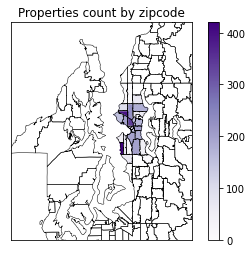

In [43]:
# Properties count

shapefile = 'Zip_Codes-shp/Zip_Codes'
colormap = plt.cm.Purples 

#Seattle coordinates
# lowerlon = -123
# upperlon = -119
# lowerlat = 46.2
# upperlat = 49

lowerlon = -123
upperlon = -122
lowerlat = 47.2
upperlat = 48

m = Basemap(
    llcrnrlon=lowerlon,
    llcrnrlat=lowerlat,
    urcrnrlon=upperlon,
    urcrnrlat=upperlat,
    projection="lcc",
    resolution="c",
    lat_0=lowerlat,
    lat_1=upperlat,
    lon_0=lowerlon,
    lon_1=upperlon
    )


shp_info = m.readshapefile(shapefile,'states',drawbounds=True
    )


popdens = {
    str(i):j for (i, j) in zip(df['zipcode'].unique(),df.groupby('zipcode')['id'].count())
    }

# Choose a color for each state based on population density. Range
# vmin-vmax has arbitrarily been set to 0-6. Fee lfree to experiment 
# with other ranges.
ziplist = []
colors  = {}
vmin    = 0
vmax    = df.groupby('zipcode')['id'].count().max()


# Filter m.states_info to only Seattle zipcodes.
zip_info   = m.states_info
popdiv     = (max(popdens.values())/(vmax-vmin))
popdensscl = {i:(j/popdiv) for (i,j) in popdens.items()}


for d in zip_info:
    iterzip = str(d['ZIP'])
    iterzip = iterzip.replace(iterzip, '{}'.format(iterzip))

    if iterzip in popdensscl.keys():
        iterpop = popdensscl.get(iterzip,0)
        colors[iterzip] = colormap(iterpop/vmax)[:3]
    ziplist.append(iterzip)


for nshape,seg in enumerate(m.states):
    i, j = zip(*seg)
    if ziplist[nshape] in popdensscl.keys():
        color = rgb2hex(colors[ziplist[nshape]])
        edgecolor = "#000000"
        plt.fill(i,j,color=color)


# # (Optional) include colorbar.
# sm = plt.cm.ScalarMappable(
#     cmap=colormap,norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax*5)
#     )

mm = plt.cm.ScalarMappable(cmap=colormap)
mm.set_array([vmin, vmax])
plt.colorbar(mm,ticks=np.arange(vmin, vmax, 100),orientation="vertical")
plt.title('Properties count by zipcode')

plt.savefig('Properties count by zipcode', bbox_inches = 'tight')
plt.show();

In [40]:
# Percent of time booked

colormap = plt.cm.Purples 

#Seattle coordinates
# lowerlon = -122
# upperlon = -119
# lowerlat = 46.2
# upperlat = 49

lowerlon = -123
upperlon = -122
lowerlat = 47.2
upperlat = 48

m = Basemap(
    llcrnrlon=lowerlon,
    llcrnrlat=lowerlat,
    urcrnrlon=upperlon,
    urcrnrlat=upperlat,
    projection="lcc",
    resolution="c",
    lat_0=lowerlat,
    lat_1=upperlat,
    lon_0=lowerlon,
    lon_1=upperlon
    )


shp_info = m.readshapefile(shapefile,'states',drawbounds=True
    )


popdens = {
    str(i):j for (i, j) in zip(df['zipcode'].unique(),df.groupby('zipcode')['booked_days'] \
                               .apply(lambda x: x.sum()/(x.count()*365)))
    }

# Choose a color for each state based on population density. Range
# vmin-vmax has arbitrarily been set to 0-6. Fee lfree to experiment 
# with other ranges.
ziplist = []
colors  = {}
vmin    = 0
vmax    = df.groupby('zipcode')['booked_days'] \
                               .apply(lambda x: x.sum()/(x.count()*365)).max()


# Filter m.states_info to only Seattle zipcodes.
zip_info   = m.states_info
popdiv     = (max(popdens.values())/(vmax-vmin))
popdensscl = {i:(j/popdiv) for (i,j) in popdens.items()}


for d in zip_info:
    iterzip = str(d['ZIP'])
    iterzip = iterzip.replace(iterzip, '{}'.format(iterzip))

    if iterzip in popdensscl.keys():
        iterpop = popdensscl.get(iterzip,0)
        colors[iterzip] = colormap(iterpop/vmax)[:3]
    ziplist.append(iterzip)


for nshape,seg in enumerate(m.states):
    i, j = zip(*seg)
    if ziplist[nshape] in popdensscl.keys():
        color = rgb2hex(colors[ziplist[nshape]])
        edgecolor = "#000000"
        plt.fill(i,j,color=color)


mm = plt.cm.ScalarMappable(cmap=colormap)
mm.set_array([vmin, vmax])
plt.colorbar(mm,ticks=np.arange(vmin, vmax, 0.2),orientation="vertical")
plt.title('Percent of time booked by zipcode')

plt.savefig('Percent of time booked by zipcode',  bbox_inches = 'tight')
plt.show();

OSError: cannot locate Zip_Codes.dbf

## Number of reviews

In [ ]:
plt.scatter(data=df, x='number_of_reviews', y = 'booked_days')
plt.title('Bookings per number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Number of booked days')
plt.savefig('Bookings per number of reviews');

## Price per person

In the dataset we have a field with price. Since usually bigger places are more expensive than smaller ones, we need to normalize the price. We are going to do that by using the field 'accommodates' which contains the number of persons the property can accommodate.

In [ ]:
df['price_per_person'] = df['price']/df['accommodates']
plt.scatter(data=df, x='price_per_person', y = 'booked_days')
plt.title('Bookings per price')
plt.xlabel('Price per person')
plt.ylabel('Number of booked days')
plt.savefig('Bookings per price');